# Benchmarks

## Initialize

In [40]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

In [41]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label = "22_retina_phewas"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = '220812_test'
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [42]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y=element_line()))

In [43]:
colors_dict = read_json("colors.json")
color_map <- c(
    "Age+Sex" = colors_dict$pastel$red$mid,
    "Retina" = colors_dict$pastel$red$mid,
    "Age+Sex+Retina" = colors_dict$pastel$red$mid,
    'MultiTaskSurvivalTraining_None_InceptionResnetV2+MLP_Identity' = colors_dict$pastel$red$mid
    #"Identity(AgeSex)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(Records)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid
)

In [44]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)

In [45]:
endpoint_map = endpoint_defs$phecode_string
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [46]:
endpoint_selection = c(
    # generally very important
    "phecode_202", # Diabetes mellitus
    "phecode_404", # Ischemic heart disease
    "phecode_404-1", # Myocardial infarction [Heart attack]
    "phecode_431-11", # Cerebral infarction [Ischemic stroke]
    "phecode_424", # Heart failure
    "OMOP_4306655", # All-Cause Death
    # also generally important and relevant
    #"phecode_440-3", # Pulmonary embolism
    #"phecode_468-1",	#Viral pneumonia
    "phecode_401",	#Hypertension"
    "phecode_460-2",	#Acute lower respiratory infection
    "phecode_468", # Pneumonia
    "phecode_474", # Chronic obstructive pulmonary disease [COPD]
    "phecode_542", # Chronic liver disease and sequelae
    "phecode_583", # Chronic kidney disease
    "phecode_328", # Dementias and cerebral degeneration
    
    
    # generally important and fun to check
    "phecode_164", # Anemia
   # "phecode_726-1", # Osteoporosis
    "phecode_286-2", #	Major depressive disorder
    "phecode_103", # Malignant neoplasm of the skin
    "phecode_101", # Malignant neoplasm of the digestive organs
    #"phecode_665", # Psoriasis
    "phecode_121", # Leukemia
    "phecode_705-1", # Rheumatoid arthritis
    
    
    # important for eye
    "phecode_371", # Cataract
   # "phecode_374-3", # Retinal vascular changes and occlusions
    "phecode_374-42", # Diabetic retinopathy
    "phecode_374-5", # Macular degeneration
    "phecode_375-1" # Glaucoma
    #"phecode_388" # Blindness and low vision
)

endpoints_common = c(
   'phecode_164', #Anemia
 'phecode_705-1', #Rheumatoid arthritis
 'phecode_328', #Dementias and cerebral degeneration
 'phecode_328-1', #Alzheimer's disease
 'phecode_401', #Hypertension
 'phecode_202', #Diabetes mellitus
 'phecode_416-21', #Atrial fibrillation
 'phecode_404-1', #Myocardial infarction [Heart attack]
 'phecode_424', #Heart failure
 'phecode_468', #Pneumonia
 'phecode_474', #Chronic obstructive pulmonary disease [COPD]
 'phecode_583', #Chronic kidney disease
 'OMOP_4306655' #All-Cause Death
    )
    
endpoints_cardio = c(
    'phecode_438-11',   #  "Abdominal aortic aneurysm",
    'phecode_440-3',#  "Pulmonary embolism", # intervention
    'phecode_413-21',#  "Aortic stenosis", # intervention
    'phecode_400'#  "Rheumatic fever and chronic rheumatic heart diseases",	
)

endpoints_eye= c(
    'phecode_374-5', #Macular degeneration
 'phecode_374-51', #Age-related macular degeneration
 'phecode_374-42', #Diabetic retinopathy
 'phecode_371', #Cataract
 'phecode_388', #Blindness and low vision
 'phecode_367-5', #Uveitis
 'phecode_389-1' #Ocular pain
)

In [47]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>%
    mutate(name = 
           case_when( 
               phecode_string == "Myocardial infarction [Heart attack]"~"Myocardial infarction",
               phecode_string == "Cerebral infarction [Ischemic stroke]"~"Ischemic stroke",
               phecode_string == "Chronic obstructive pulmonary disease [COPD]"~"Chronic obstructive pulmonary disease",
               phecode_string == "Mitral valve insufficiency"~"Mitral insufficiency",
               phecode_string == "Parkinson's disease (Primary)"~"Parkinson's disease",
               phecode_string == "Suicide ideation and attempt or self harm"~"Suicide attempt",
               phecode_string == "Ischemic heart disease"~"Coronary heart disease",
               phecode_string == "Chronic kidney disease"~"Chronic kidney disease",
               phecode_string == "Rheumatic fever and chronic rheumatic heart diseases"~"Rheumatic heart disease",
               phecode_string == "Abdominal aortic aneurysm"~"Abdominal aortic aneurysm",
                  TRUE ~ name)
           )
            
endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
#endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint
endpoint_order = endpoint_selection

## Load data

# Load Benchmarks

In [9]:
#today = substr(Sys.time(), 0, 10) # YYYY-MM-DD
today = '221103'

In [10]:
#name = glue("benchmark_cindex_agesexcoxph_{today}")
name = glue("benchmarks_cindex_{today}")
crop_ratio = "0.66" # 0.3, 0.5, 0.8
benchmark_endpoints = arrow::read_feather(glue("{experiment_path}/{name}.feather")) %>% left_join(endpoint_defs) 

Joining, by = "endpoint"


In [11]:
benchmark_endpoints = benchmark_endpoints %>%
    filter(model == glue("ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio{crop_ratio}"))

In [12]:
benchmark_endpoints %>% group_by(endpoint, score)  %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


score,mean(cindex)
<chr>,<dbl>
Age+Sex,0.6043653
Retina,0.6069311
Age+Sex+Retina,0.6172028
SCORE2,0.6208751
SCORE2+Retina,0.6257421
ASCVD,0.6266720
ASCVD+Retina,0.6272206
QRISK3+Retina,0.6377905
QRISK3,0.6384638


In [13]:
endpoints_sorted = (benchmark_endpoints %>% 
    filter(score == "Age+Sex+Retina") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


In [14]:
categories_sorted = (endpoint_defs %>% distinct(phecode_category))$phecode_category

## delta c-idx with negative values

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can
override using the `.groups` argument.


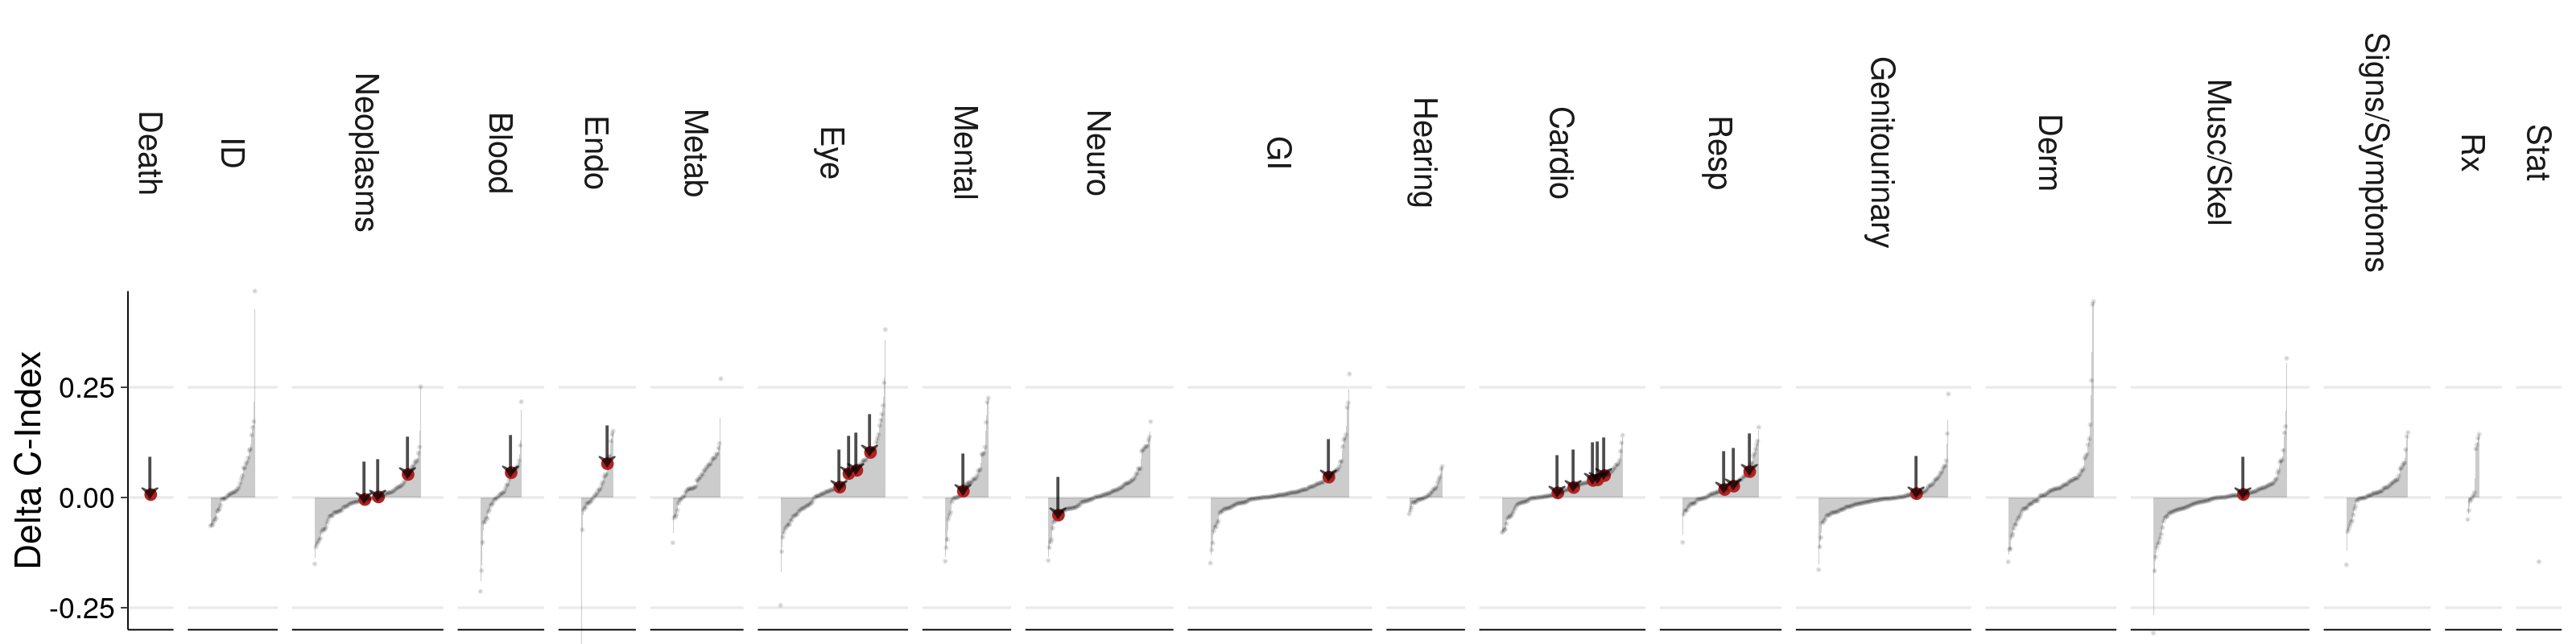

In [15]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp %>% arrange(delta))$endpoint

temp = temp %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% ungroup() %>% arrange(endpoint) %>% group_by(phecode_category) %>% mutate(endpoint = row_number())

ggplot(temp) +
    geom_ribbon(aes(x=endpoint, ymin=0, ymax=delta), fill="black", alpha=0.2)+
    geom_point(aes(x=endpoint, y=delta, color=highlight, size=highlight, alpha=highlight)) +
    geom_text(data=temp %>% filter(highlight=="YES"), aes(x=endpoint, y=delta+0.045, label="↓"), color="black", size=5, alpha=0.7) +
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    labs(x="Endpoints", y=glue("Delta C-Index"))+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    scale_alpha_manual(values=c("NO"=0.1, "YES"=1))+
    scale_size_manual(values=c("NO"=0.01, "YES"=1))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    #coord_polar() +
    coord_cartesian(ylim=c(-0.3, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=20))+
    facet_grid(~phecode_category, scales="free_x", space="free_x")+#, switch=TRUE)+
    #facet_grid2(~phecode_category, scales = "free", independent = "all") + 
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major=element_blank(), 
         strip.text = element_text(angle=270)) + 
    theme(legend.position="none") 
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

## delta c-idx with positive values (negative set to 0)

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can
override using the `.groups` argument.


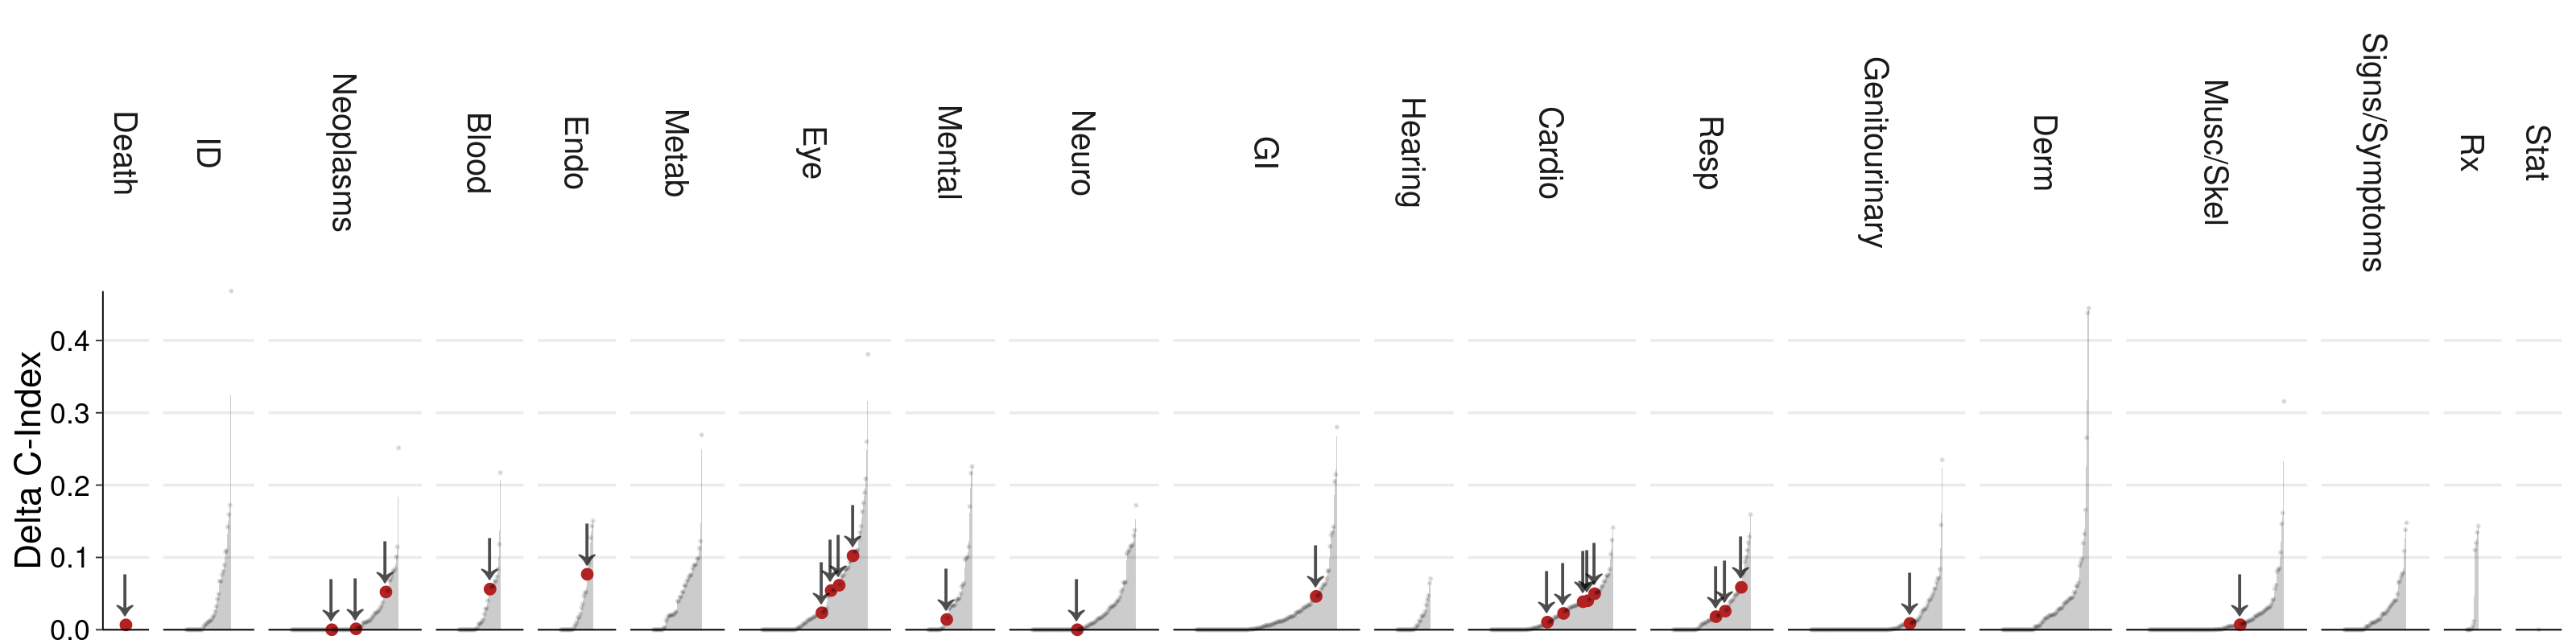

In [16]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp_pos = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`)

index <- temp_pos$delta < 0
temp_pos$delta[index] <- 0.

temp_pos = temp_pos %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp_pos %>% arrange(delta))$endpoint

temp_pos = temp_pos %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% ungroup() %>% arrange(endpoint) %>% group_by(phecode_category) %>% mutate(endpoint = row_number())

ggplot(temp_pos) +
    geom_ribbon(aes(x=endpoint, ymin=0, ymax=delta), fill="black", alpha=0.2)+
    geom_point(aes(x=endpoint, y=delta, color=highlight, size=highlight, alpha=highlight)) +
    geom_text(data=temp_pos %>% filter(highlight=="YES"), aes(x=endpoint, y=delta+0.045, label="↓"), color="black", size=5, alpha=0.7) +
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    labs(x="Endpoints", y=glue("Delta C-Index"))+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    scale_alpha_manual(values=c("NO"=0.1, "YES"=1))+
    scale_size_manual(values=c("NO"=0.01, "YES"=1))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    #coord_polar() +
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=20))+
    facet_grid(~phecode_category, scales="free_x", space="free_x")+#, switch=TRUE)+
    #facet_grid2(~phecode_category, scales = "free", independent = "all") + 
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major=element_blank(), 
         strip.text = element_text(angle=270)) + 
    theme(legend.position="none") 
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

In [17]:
plot_width = 8.25; plot_height=2; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Retina", "Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #mutate(delta_int = `Age+Sex+Retina`-`Age+Sex+Retina`) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%
    filter(endpoint %in% endpoint_selection)
    #%>%
    #summarise(cindex = mean(cindex)) 
temp %>% head()

endpoint,model,iteration,time,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name,Age+Sex,Retina,Age+Sex+Retina,id,delta,pos,highlight
<fct>,<chr>,<int>,<int>,<chr>,<chr>,<fct>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
OMOP_4306655,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,24,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.7430262,0.7465926,0.7525044,1,0.009478194,pos,YES
phecode_101,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,24,10,101,Malignant neoplasm of the digestive organs,Neoplasms,Both,0,101,0,Malignant neoplasm of the digestive organs,0.6796463,0.6711737,0.6778448,43,-0.001801458,neg,YES
phecode_103,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,24,10,103,Malignant neoplasm of the skin,Neoplasms,Both,0,103,0,Malignant neoplasm of the skin,0.6653597,0.6472087,0.6698556,53,0.004495903,pos,YES
phecode_121,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,24,10,121,Leukemia,Neoplasms,Both,0,121,0,Leukemia,0.6628511,0.7292615,0.7311899,88,0.068338864,pos,YES
phecode_164,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,24,10,164,Anemia,Blood,Both,0,164,0,Anemia,0.5924431,0.6428315,0.6483290,140,0.055885914,pos,YES
phecode_202,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,24,10,202,Diabetes mellitus,Endo,Both,0,202,0,Diabetes mellitus,0.5987453,0.6737826,0.6809642,186,0.082218947,pos,YES


In [18]:
library(ggdist)

Warning message:
“package ‘ggdist’ was built under R version 4.0.5”


In [19]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major=element_line()))

In [20]:
endpoint_selection 

[1] "phecode_202"    "phecode_404"    "phecode_404-1"  "phecode_431-11"
 [5] "phecode_424"    "OMOP_4306655"   "phecode_401"    "phecode_460-2" 
 [9] "phecode_468"    "phecode_474"    "phecode_542"    "phecode_583"   
[13] "phecode_328"    "phecode_164"    "phecode_286-2"  "phecode_103"   
[17] "phecode_101"    "phecode_121"    "phecode_705-1"  "phecode_371"   
[21] "phecode_374-42" "phecode_374-5"  "phecode_375-1"

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



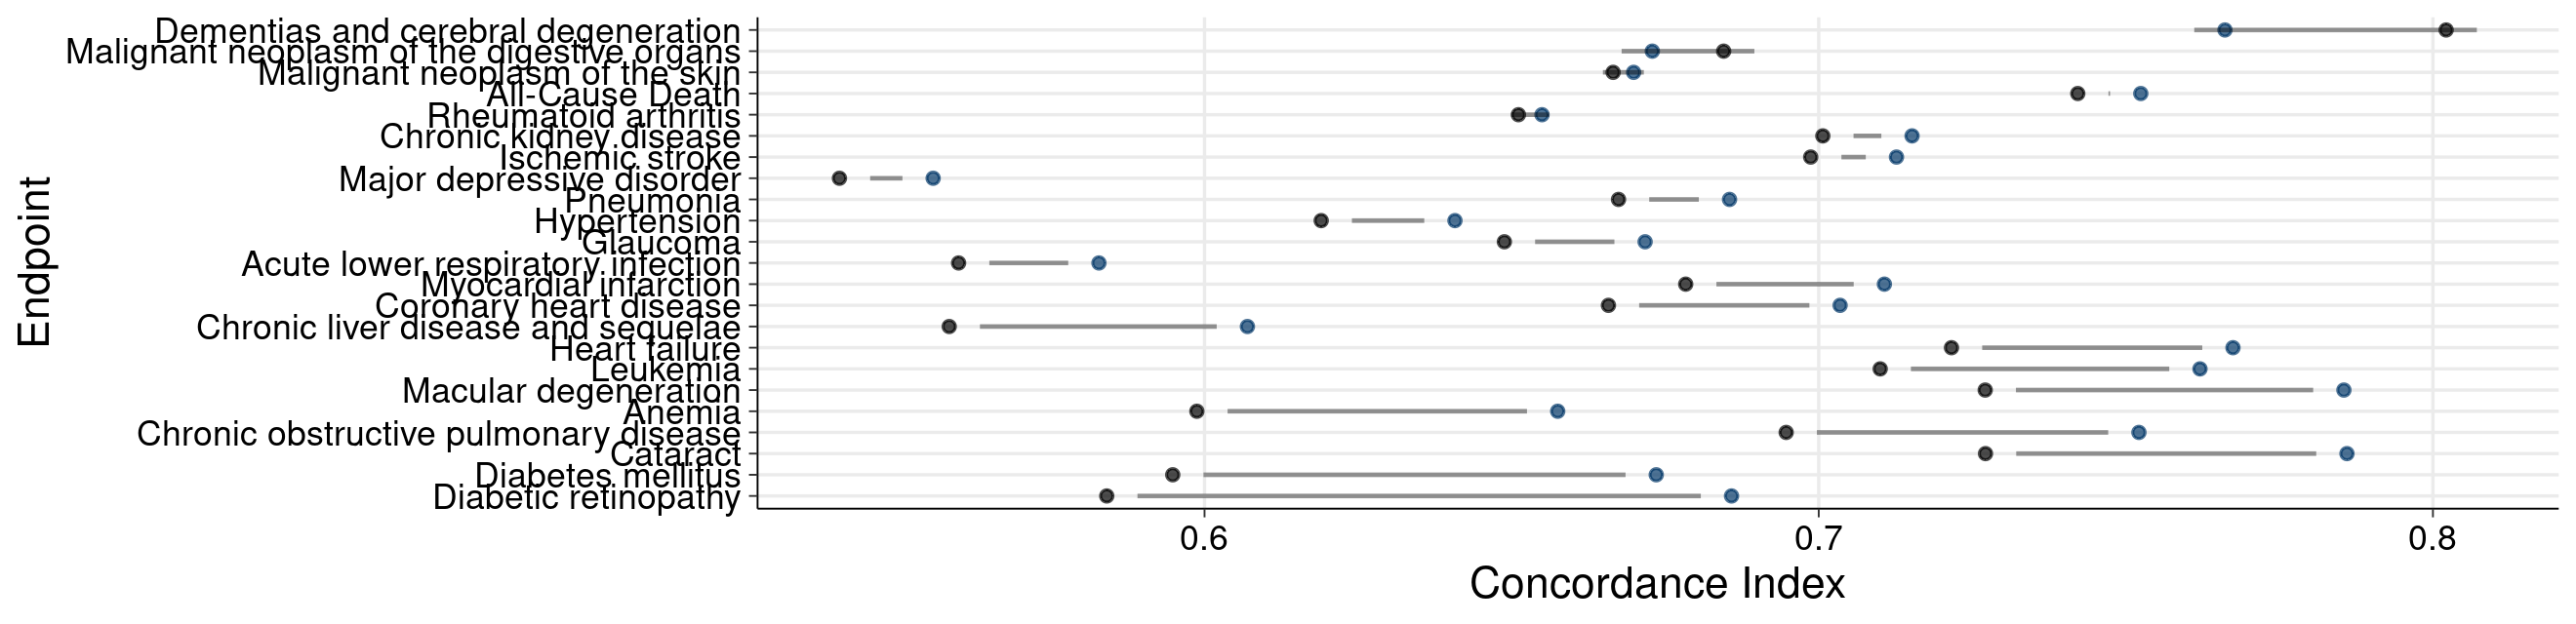

In [21]:
# temp %>% filter(endpoint %in% endpoint_selection) %>%
#     group_by(endpoint) %>%
#     summarise(m_asm=median(`Age+Sex+Retina`), m_as=median(`Age+Sex`)) %>%
#     mutate(endpoint, recode_factor(endpoint, !!!endpoint_map))

abs = ggplot(temp %>% 
             filter(endpoint %in% endpoint_selection) %>%
             group_by(endpoint) %>%
             summarise(m_asm=median(`Age+Sex+Retina`), m_as=median(`Age+Sex`))
                ) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Concordance Index", x="Endpoint")+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex`), size=1, color="black", alpha=0.3)+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex+Retina`), size=1, color="#023768", alpha=0.5)+
    geom_point(aes(x=fct_rev(endpoint), y=m_as), size=1, color="black", alpha=0.7)+
    geom_point(aes(x=fct_rev(endpoint), y=m_asm), size=1, color="#023768", alpha=0.7)+
    geom_segment(aes(x=endpoint, xend=endpoint, y=m_as+0.005, yend=m_asm-0.005), alpha=0.4)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_x_discrete(labels=endpoint_map) +
    #scale_x_discrete(labels=function(endpoint_map) formatC(endpoint_map, width=5)) +
    #scale_y_continuous(expand=c(0, 0))+
    #theme(axis.title.x=element_blank(),
     #   axis.text.x=element_blank(),
      #  axis.ticks.x=element_blank(),
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)
abs 

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



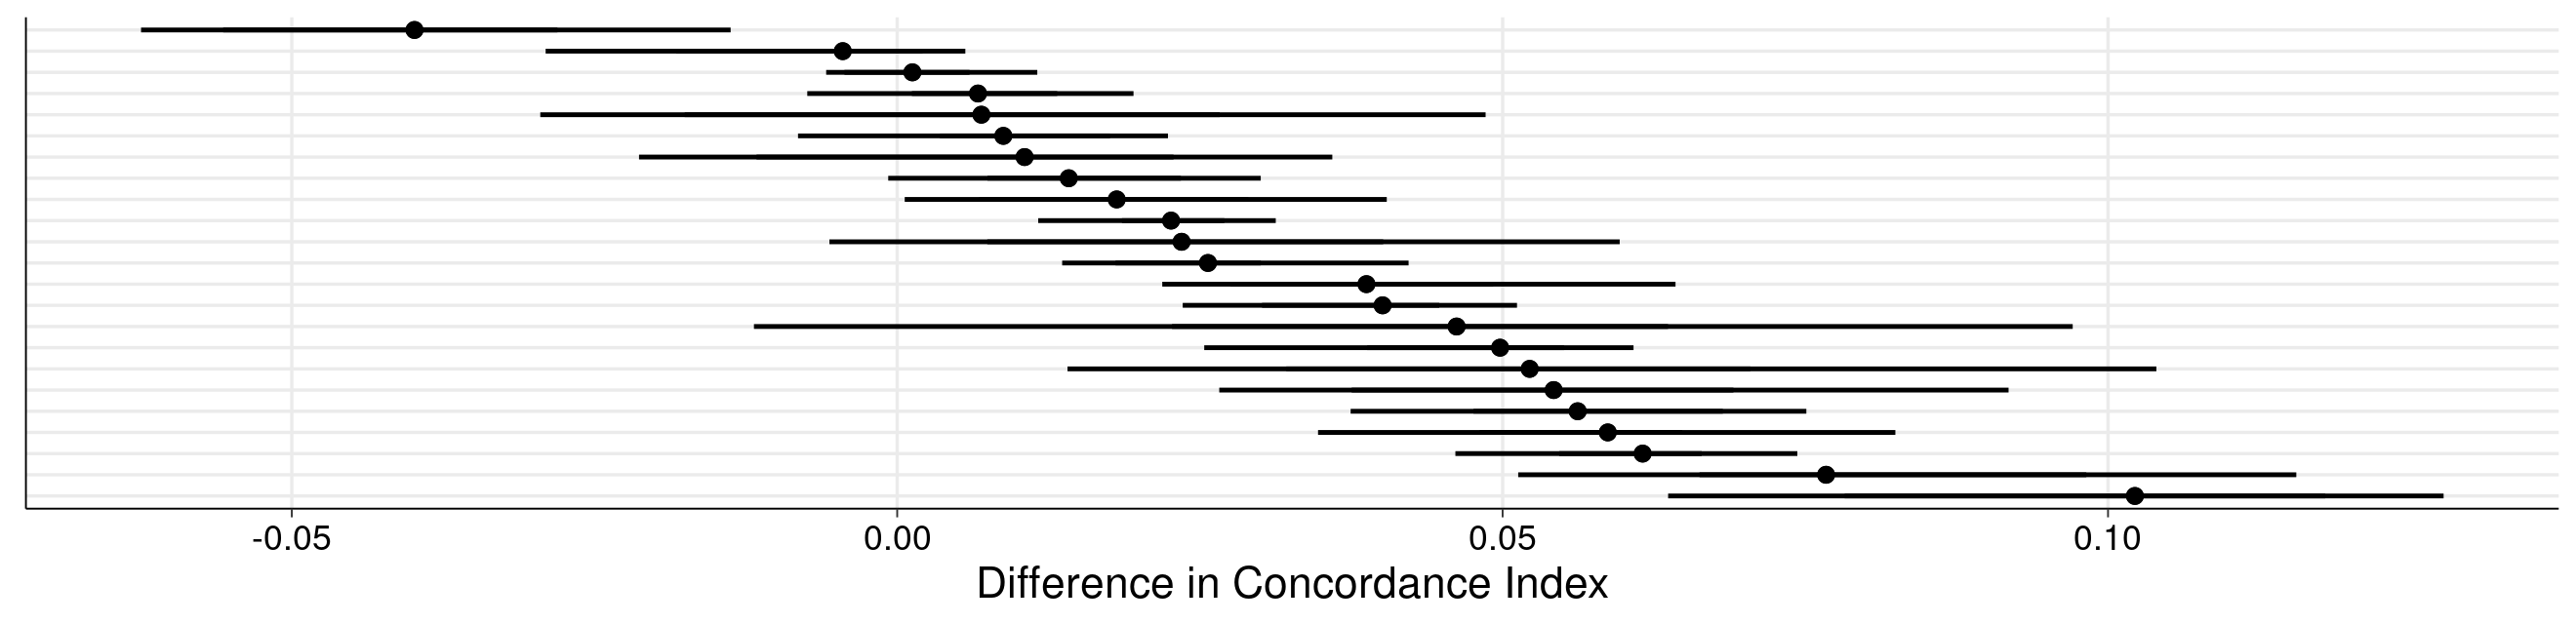

In [22]:
rel = ggplot(temp) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Difference in Concordance Index")+
    stat_pointinterval(aes(x=fct_rev(endpoint), y=delta), size=0.5)+
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    #scale_y_continuous(expand=c(0, 0))+
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
       axis.ticks.y=element_blank()) + 
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
rel    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

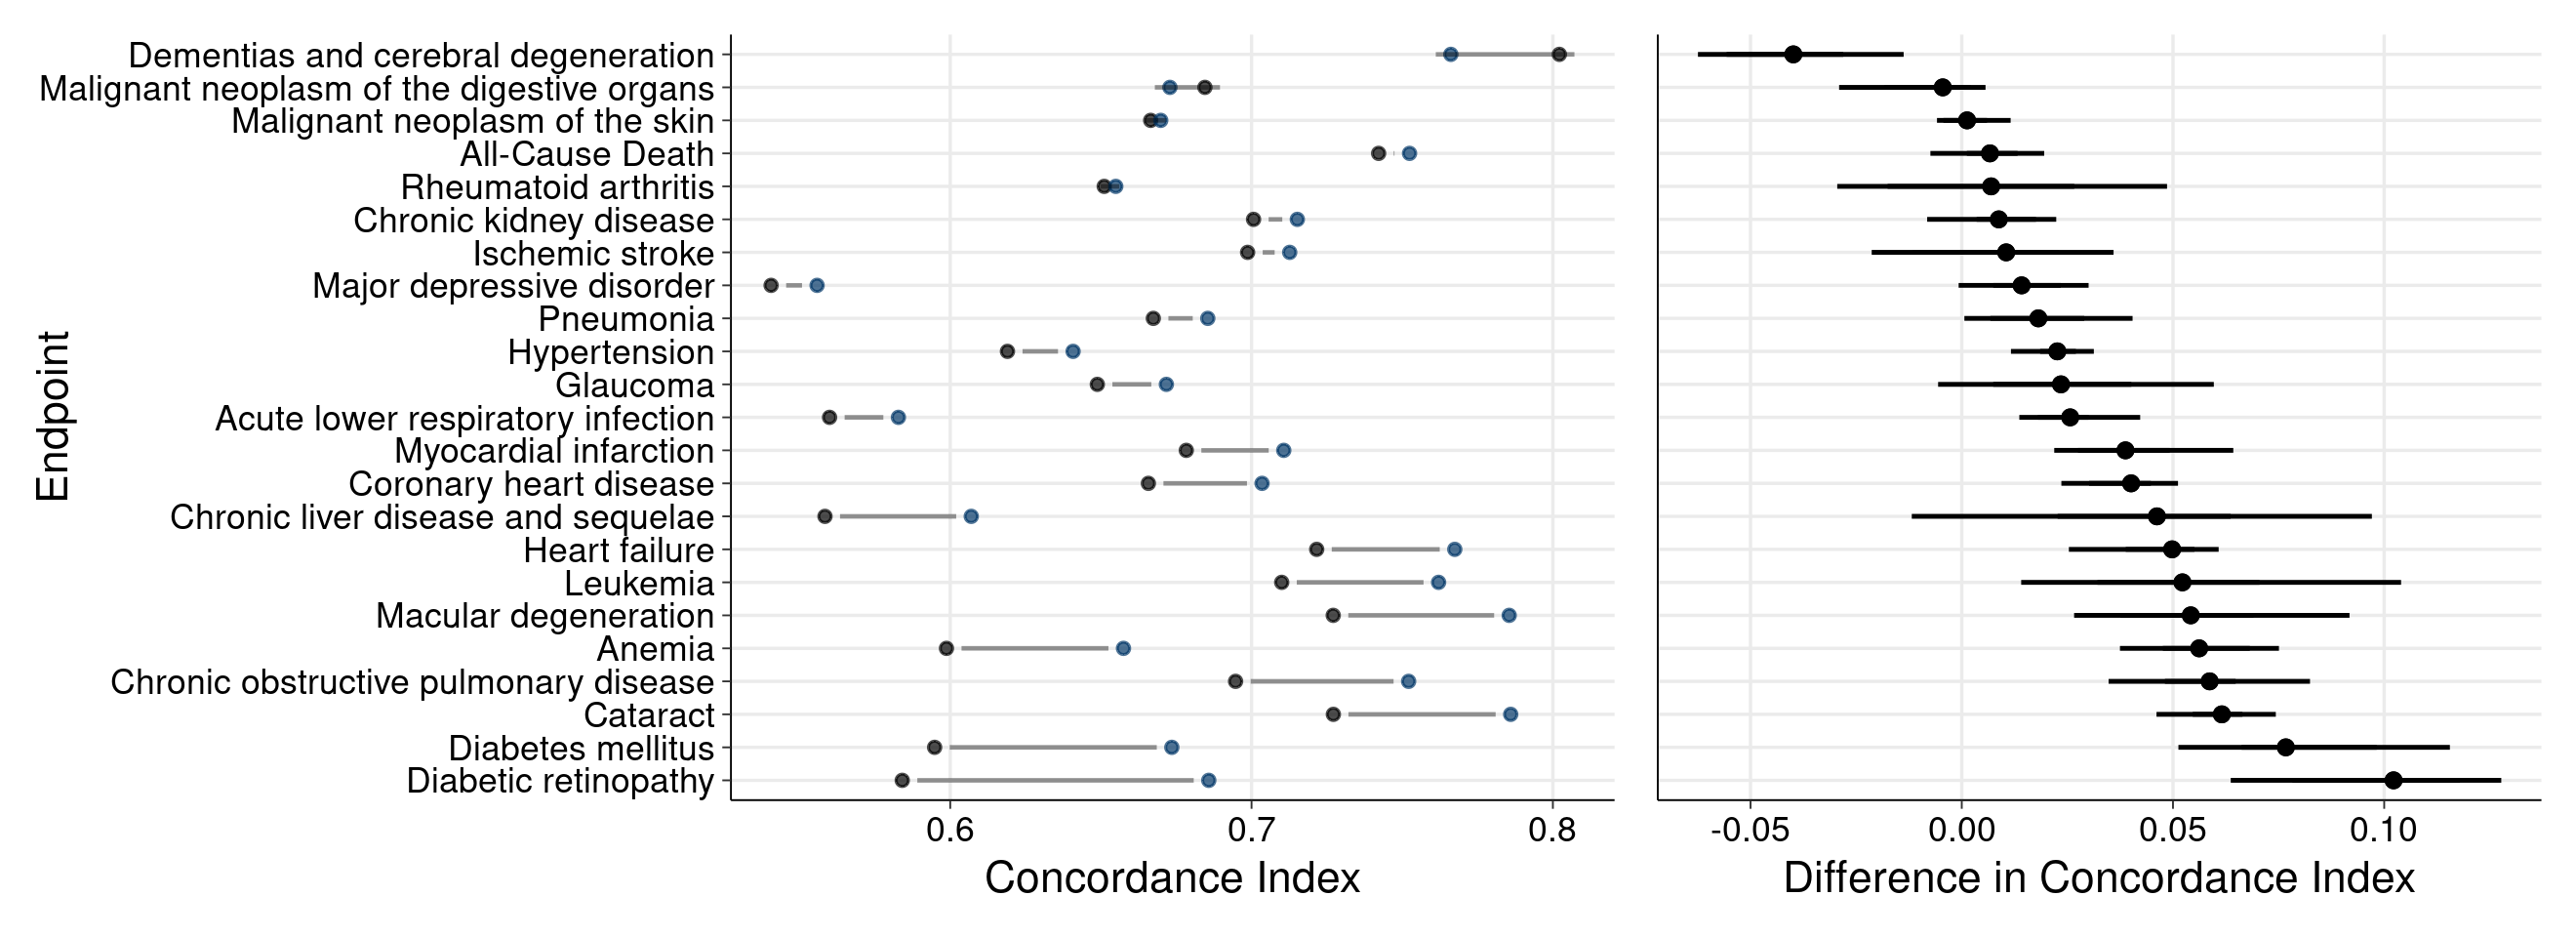

In [23]:
plot_width = 8.25; plot_height=3; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
abs|rel

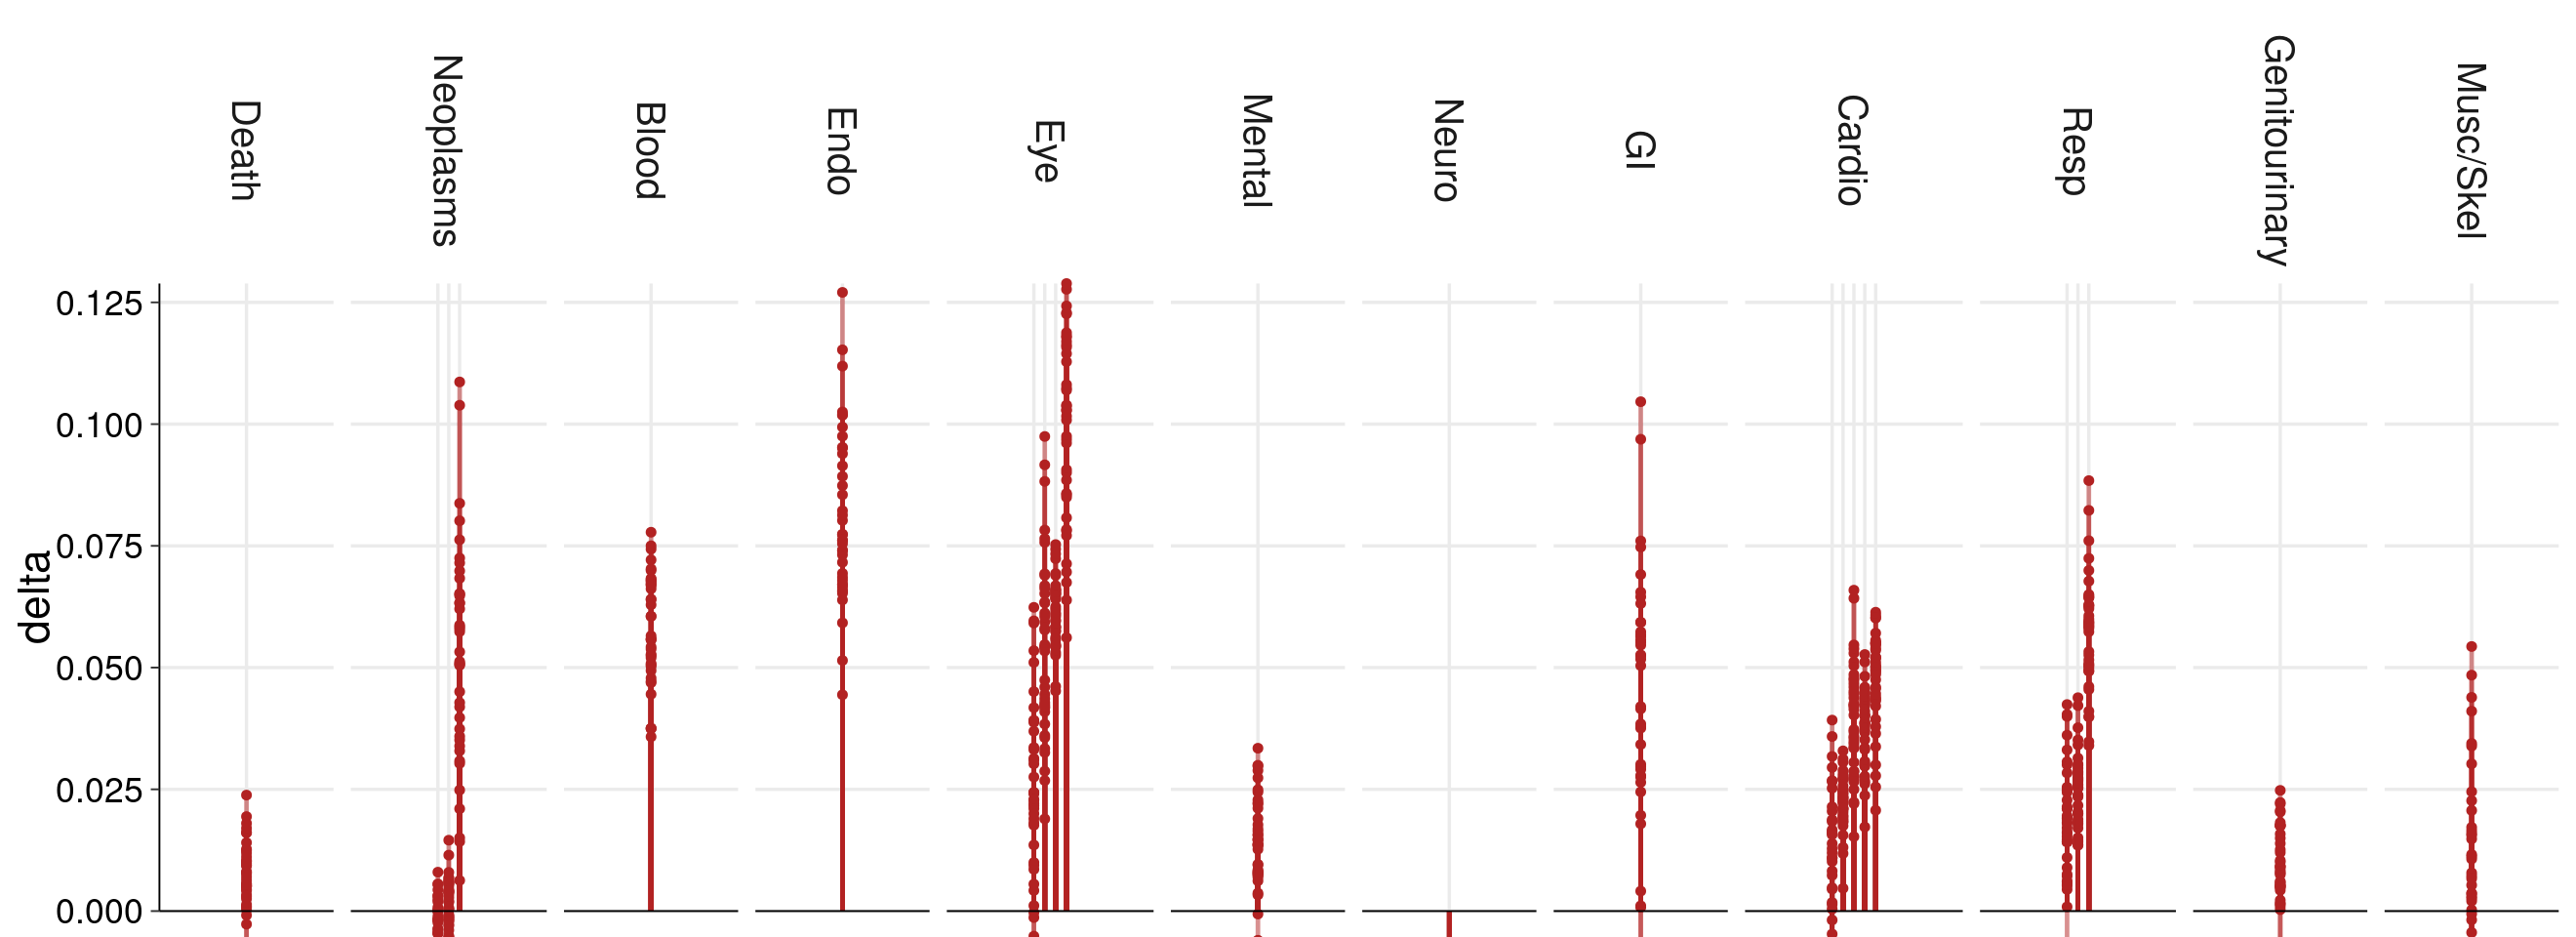

In [24]:
ggplot(temp) + 
    geom_point(aes(x=endpoint, y=delta, color=highlight), size=0.5) +
    geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=8))+
    facet_grid(~phecode_category, scale="free_x", space="free_x")+#, switch=TRUE)+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
     strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+MedicalHistory`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

In [25]:
library(ggdist)

In [26]:
table_2_pre = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    median_qi(delta)
    #mutate(posdelta = case_when(delta>=0 ~ "pos", delta < 0 ~"neg"))
#table_2_pre %>% head()
print(nrow(table_2_pre))

cat("nrows with positive lower q of delta:", nrow(table_2_pre %>% filter(.lower > 0)))
cat("\nnrows with negative lower q of delta:", nrow(table_2_pre %>% filter(.lower <= 0)))
cat("\nnrows with positive delta:", nrow(table_2_pre %>% filter(delta > 0)))
cat("\nnrows with negative delta:", nrow(table_2_pre %>% filter(delta <= 0)))

[1] 1171
nrows with positive lower q of delta: 232
nrows with negative lower q of delta: 939
nrows with positive delta: 694
nrows with negative delta: 477

In [27]:
table_2_significant = table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint)

In [28]:
options(repr.matrix.max.rows=1500, repr.matrix.max.cols=200)


table_2_significant %>% arrange(desc(delta))

endpoint,phecode_string,phecode_category,delta,.lower,.upper,.width,.point,.interval
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
phecode_005,Mycobacteria,ID,0.468271229,0.0429612326,0.600718510,0.95,median,qi
phecode_674-1,Hypopigmentation,Derm,0.444641061,0.1130040934,0.856318721,0.95,median,qi
phecode_674-11,Vitiligo,Derm,0.438178792,0.1377017476,0.878495935,0.95,median,qi
phecode_369-5,Hereditary corneal dystrophies,Eye,0.380937529,0.2002223601,0.463510696,0.95,median,qi
phecode_724-51,Calcaneal spur,Musc/Skel,0.315739800,0.1528886646,0.488222424,0.95,median,qi
phecode_546-3,Hepatomegaly,GI,0.280245245,0.2093692023,0.328325693,0.95,median,qi
phecode_248,"Disorders of plasma-protein metabolism, NEC",Metab,0.269420403,0.0666425267,0.337934935,0.95,median,qi
phecode_676-1,Hypertrophic scar [Keloid scar],Derm,0.265469862,0.1358884380,0.456839582,0.95,median,qi
phecode_374-8,Retinal edema,Eye,0.260146105,0.1362596156,0.357710957,0.95,median,qi


In [29]:
table_2_significant %>% group_by(phecode_category) %>% count() %>% mutate(freq=n/ 283)

phecode_category,n,freq
<chr>,<int>,<dbl>
Blood,9,0.03180212
Cardio,33,0.11660777
Derm,21,0.07420495
Endo,6,0.02120141
Eye,33,0.11660777
Genitourinary,9,0.03180212
GI,20,0.07067138
Hearing,4,0.01413428
ID,7,0.02473498


In [30]:
table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable2_SignificantEndpoints_CropRatio-{crop_ratio}.csv"))

In [31]:

table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable2_SignificantEndpoints_CropRatio-{crop_ratio}.csv"))

In [ ]:
benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, `Age+Sex`, `Age+Sex+Retina`, delta) %>%
    pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
ungroup() %>%
    pivot_wider(names_from=type, values_from=cindex) %>%
select(phecode_string, `Age+Sex+Retina`, `Age+Sex`, delta) #%>% filter(delta>0) %>% arrange(desc(`Age+Sex+Retina`))


In [ ]:
table_2 = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #select(endpoint, iteration, phecode_string, phecode_category, sex, `Age+Sex`, `Age+Sex+Retina`, delta) %>%
    pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>%
    #ungroup() %>%
    mutate(agg = glue("{round(cindex, 3)} ({round(.lower, 3)}, {round(.upper, 3)})")) %>%
    ungroup() %>% select(endpoint, phecode_string, phecode_category, type, agg) %>%
    pivot_wider(names_from=type, values_from=agg)
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    #mutate(endpoint = fct_reorder(endpoint, delta))# %>% filter(endpoint %in% endpoint_sample)

In [ ]:
table_2 %>% 
    select(all_of(c("endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint)

In [ ]:
options(pillar.print_max = Inf)
table_2 %>% 
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    #filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable1_DiscriminativePerformanceAll_CropRatio-{crop_ratio}.csv"))

In [ ]:
options(pillar.print_max = Inf)
table_2 %>% 
    arrange(as.character(endpoint)) %>%
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable1_DiscriminativePerformanceEndpointSelection_CropRatio-{crop_ratio}.csv"))

# SOME QC -> where do the NaNs come from?

In [ ]:
benchmark_endpoints %>% head()

In [ ]:
tmp = benchmark_endpoints %>% select(endpoint, phecode_string, iteration, cindex)
tmp[!complete.cases(tmp),]

In [ ]:
tmp %>% select(phecode_string) %>% count()